In this notebook, we train a XGBoost and then try to find a global representation (through a plot) of its hundreds of trees, after it has been trained (i.e. post-hoc). 

To that end, we overfit a basic decision tree on the XGBoost's predictions, and then plot this basic tree. 

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Basic data preparation, modelling and analysis for binary classification (Census)

## Train a model only with a statistical performance purpose

In [2]:
import sys
sys.path.append("../")

import pickle
import time
from sklearn.datasets import fetch_openml

from classif_basic.data_preparation import train_valid_test_split, set_target_if_feature, automatic_preprocessing
from classif_basic.model import train_naive_xgb, pickle_save_model, prediction_train_valid_by_task, compute_best_fscore
from classif_basic.model_analysis import features_importances_from_pickle, augment_train_valid_set_with_results

from classif_basic.model_analysis import plot_tree, get_df_first_splits

In [3]:
# set your statistics purposes
model_task = 'classification'
stat_criteria = 'auc'

t0 = time.time()

### Prepare data

We volontary bias the dataset to fix a "sexist" effect, s.t. gender has an effect on revenue (i.e. the target Y). In that way, we control for the causal relationship with gender as a causal parent for revenue, that the model should reflect - and hence its representation (70% of wealthy clients given they are men, 10% if they are women).

In [84]:
# preparing the dataset on clients for binary classification
#from sklearn.datasets import fetch_openml
data = fetch_openml(data_id=1590, as_frame=True)

X = data.data
Y = (data.target == '>50K') * 1

In [85]:
dataset = X.copy()
dataset['target'] = Y
dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,0


First tree (/ graph?) with initial features (that will be transformed with one-hot encoding for XGBoost's further modelling)?

In [97]:
#pip install anytree 

from anytree import Node, RenderTree
from anytree.exporter import DotExporter

census_tree = Node("sex") #root 
    #What about another root, e.g. 'biological' feature as race (and country, occupation = sociological background => fnwlgt) or sex? 
    # May be only possible with a graph
a_1 = Node("education", parent=census_tree)
aa_1 = Node("education num", parent=a_1)
b_1 = Node("occupation", parent=aa_1)
b_3 = Node("hours per week", parent=b_1)
c_1 = Node("workclass", parent=b_1)
d_1 = Node("capital_loss", parent=c_1)
d_2 = Node("capital_gain", parent=c_1)
d_3 = Node("hours per week", parent=c_1)

a_2 = Node("relationship", parent=census_tree)
v_1 = Node("marital status", parent=a_2)
w_1 = Node("occupation", parent=v_1)

# age -> occupation, age -> capital gain, age -> marital status 
a_3 = Node("age", parent=census_tree) # mandatory to have only one parent, but makes no logical sense...
k_1 = Node("occupation", parent=a_3)
k_2 = Node("capital_gain", parent=a_3)
k_3 = Node("marital status", parent=a_3)

# race -> occupation, race -> native country -> occupation
a_4 = Node("race", parent=census_tree)
m_1 = Node("occupation", parent=a_4)
m_2 = Node("native country", parent=a_4)
n_1 = Node("occupation",parent=m_2)
o_1 = Node("fnlwgt",parent=n_1)

# education, race -> fnlwgt: possible to modelise?

# what then about "native_country", i.e. besides the 'biological' the 'descriptive' (or 'non-actionable') features?
# what about the redudancies (e.g. "education" and "education-num"? The problem will be deeper after the features will be splitted through one-hot-encoding)

DotExporter(census_tree).to_picture("census_tree.png")

In [6]:
# here, "treatment" is saw as being 'Male' and not 'Female'

df_response_if_feature=dataset.loc[(dataset['sex']=='Male')&(dataset['target']==1)]
df_no_response_if_feature=dataset.loc[(dataset['sex']=='Male')&(dataset['target']==0)]
df_response_if_not_feature=dataset.loc[(dataset['sex']=='Female')&(dataset['target']==1)]
df_no_response_if_not_feature=dataset.loc[(dataset['sex']=='Female')&(dataset['target']==0)]

print(df_response_if_feature.shape[0])
print(df_no_response_if_feature.shape[0])
print(df_response_if_not_feature.shape[0])
print(df_no_response_if_not_feature.shape[0])


# % of men selected by the initial data
df_response_if_feature.shape[0]/(df_response_if_feature.shape[0]+df_no_response_if_feature.shape[0])

9918
22732
1769
14423


0.3037672281776417

In [7]:
# % of women selected by the initial data
df_response_if_not_feature.shape[0]/(df_response_if_feature.shape[0]+df_no_response_if_not_feature.shape[0])

0.07267573230352081

In [8]:
len_dataset = 20_000

percentage_feature= 70
percentage_response_if_feature=70
percentage_response_if_not_feature=10

sexist_dataset = set_target_if_feature(
    df_response_if_feature=df_response_if_feature,
    df_no_response_if_feature=df_no_response_if_feature,
    df_response_if_not_feature=df_response_if_not_feature,
    df_no_response_if_not_feature=df_no_response_if_not_feature,
    len_dataset=len_dataset,
    percentage_feature=percentage_feature,
    percentage_response_if_feature=percentage_response_if_feature,
    percentage_response_if_not_feature=percentage_response_if_not_feature)

len_dataset: 20000
nb indivs feature with response: 9800
nb indivs feature with no response: 4200
nb indivs not_feature with response: 600
nb indivs not_feature with no response: 5400


In [9]:
X = sexist_dataset.loc[: , dataset.columns != 'target']
Y = sexist_dataset['target']

In [10]:
Y

36672    1
36624    1
25498    1
27082    1
32824    1
        ..
43327    0
13891    0
2499     0
1823     0
33047    0
Name: target, Length: 20000, dtype: int64

### Bring your own model 

If you want to bring your own model, you have to set 3 features:

1. uncorrected_model_path
Save your model in uncorrected_model_path, for fairness analysis on relevant features
Ex: uncorrected_model_path = "/work/data/models/uncorrected_model.pkl"

2. X_train_valid, Y_train_valid
pd.DataFrame with your inputs and targets on train&valid set, of shape(nb_individuals,)

3. Y_pred_train_valid
np.ndarray with the predicted label (i.e. class) or value, of shape(nb_individuals,)

### Automatically train a model statistically performant, regardless of fairness

In [11]:
X_train, X_valid, X_train_valid, X_test, Y_train, Y_valid, Y_train_valid, Y_test = train_valid_test_split(
    X=X,
    Y=Y, 
    model_task=model_task)

In [12]:
Y_valid.shape

(2550,)

Training model with 105 features, on 14450 rows (valid 2550 rows, test 3000 rows) 
[0]	validation_0-auc:0.89477	validation_1-auc:0.90334
[100]	validation_0-auc:0.95833	validation_1-auc:0.95273
[173]	validation_0-auc:0.96383	validation_1-auc:0.95318
len(thresholds): 2521
(2550,)
Best Threshold=0.416755, with F-Score=0.901


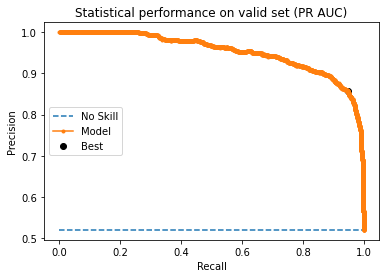

In [13]:
# save the uncorrected model, to then sort its features by importances
save_model=True
uncorrected_model_path = "/work/data/models/uncorrected_model.pkl"

Y_pred_train_valid = train_naive_xgb(
    X_train=X_train,
    X_valid=X_valid,
    X_train_valid=X_train_valid,
    X_test=X_test,
    Y_train=Y_train,
    Y_valid=Y_valid,
    Y_train_valid=Y_train_valid,
    Y_test=Y_test,
    model_task=model_task,
    stat_criteria=stat_criteria,
    save_model=save_model)

In [17]:
X_train_valid.columns

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private',
       ...
       'native-country_Portugal', 'native-country_Puerto-Rico',
       'native-country_Scotland', 'native-country_South',
       'native-country_Taiwan', 'native-country_Thailand',
       'native-country_Trinadad&Tobago', 'native-country_United-States',
       'native-country_Vietnam', 'native-country_Yugoslavia'],
      dtype='object', length=105)

We now see that this process with basic data preparation, modelling and integration of the results in a DataFrame (as storage of the model) is very fast (in seconds):

In [ ]:
t1 = time.time()

print(f"Basic modelling took {round(t1 - t0)} seconds")

# Represent XGBoost's predictions through a basic tree

Provide an (overfitted) representation of all XGBoost trees through a decision tree. 

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree as sklearn_plot_tree

import matplotlib.pyplot as plt

uncorrected_model_path = "/work/data/models/sexist_model.pkl"

file = open(uncorrected_model_path,'rb')
xgb_basic = pickle.load(file)

In [32]:
tree_posthoc = DecisionTreeClassifier(random_state=0,max_leaf_nodes=20)
# cross_val_score(tree_posthoc, X_train_valid, Y_pred_train_valid, cv=10)

tree_posthoc.fit(X_train_valid, Y_pred_train_valid)

cross_val_score(tree_posthoc, X_train_valid, Y_pred_train_valid, cv=10)

array([0.94058824, 0.93352941, 0.92941176, 0.93882353, 0.93058824,
       0.94117647, 0.94352941, 0.92882353, 0.93823529, 0.95294118])

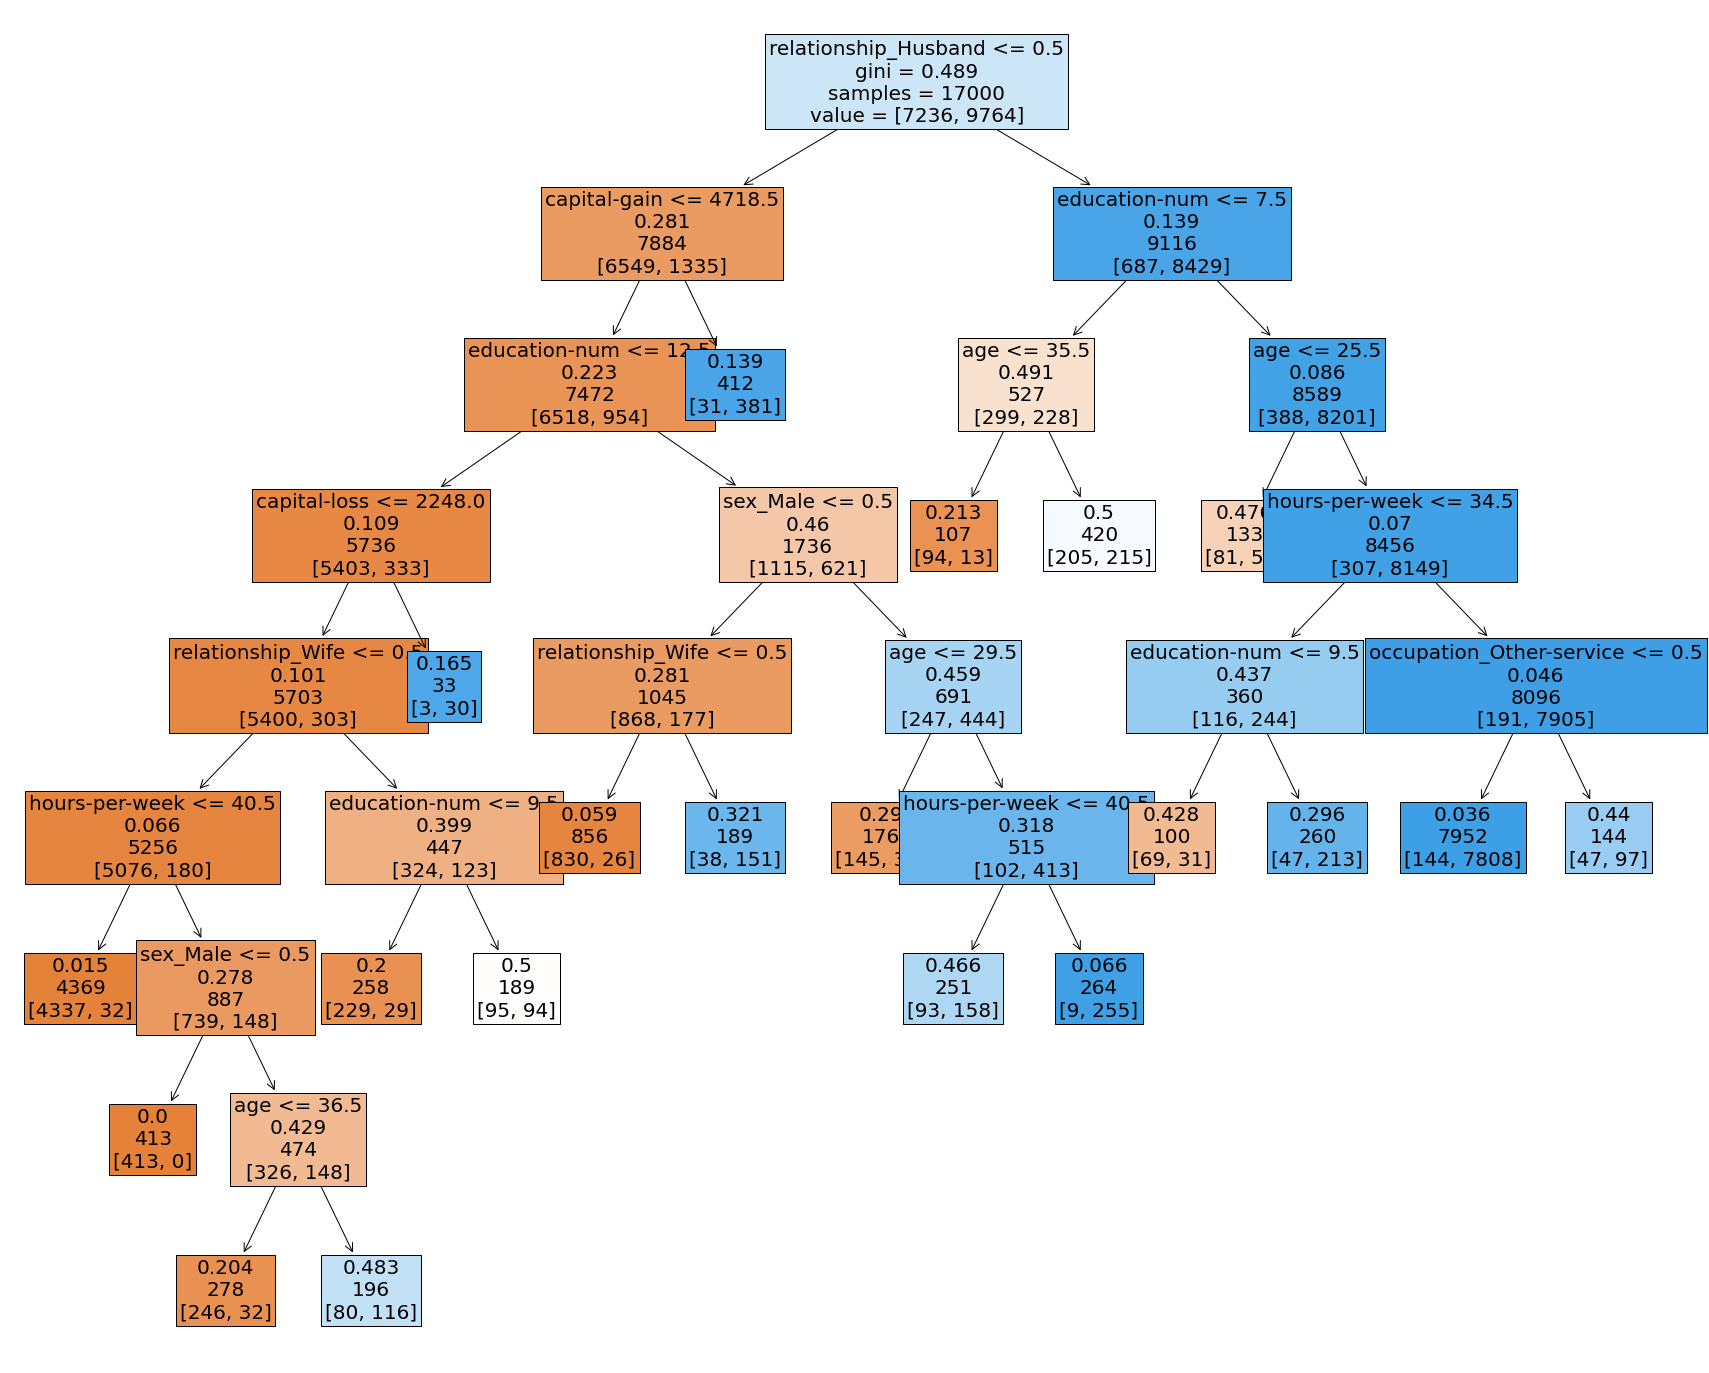

In [59]:
plt.figure(figsize = (30,25))

sklearn_plot_tree(tree_posthoc, 
                  feature_names = X_train_valid.columns, 
                  label = "root",
                  filled=True,
                  fontsize=20)

plt.show()

# Decomposition in Trees: Coherent Structure?

Though when we come inside the first node of all trees, the result is not always coherent. 

- "capital gain" is the first splitting feature in 11 > 6 trees for "marital status" which, however, appears as the first splitting feature at an aggregate level (in our 2. post-hoc representation).

- the 6 trees using "marital status" as the first feature encompass very different structures (e.g. age after marital status? or, more coherently, hours of work per week after marital status?)

In [60]:
booster = xgb_basic
get_max_split_feature=False
nb_min_trees = 6 #None

df_first_splits = get_df_first_splits(booster=booster, 
                                      get_max_split_feature=get_max_split_feature,
                                      nb_min_trees=nb_min_trees)
df_first_splits

,trees_index,nb_trees
first_splitting_feature,,
capital-gain<7055.5,"[7, 9, 14, 18, 20, 30, 51, 97, 115, 145, 160]",11
marital-status_Married-AF-spouse<1,"[22, 47, 65, 78, 119, 162]",6
capital-gain<57,"[52, 54, 98, 116, 132, 146]",6
capital-gain<8255,"[64, 76, 88, 104, 114, 131]",6


first_splitting_feature: marital-status_Married-AF-spouse<1


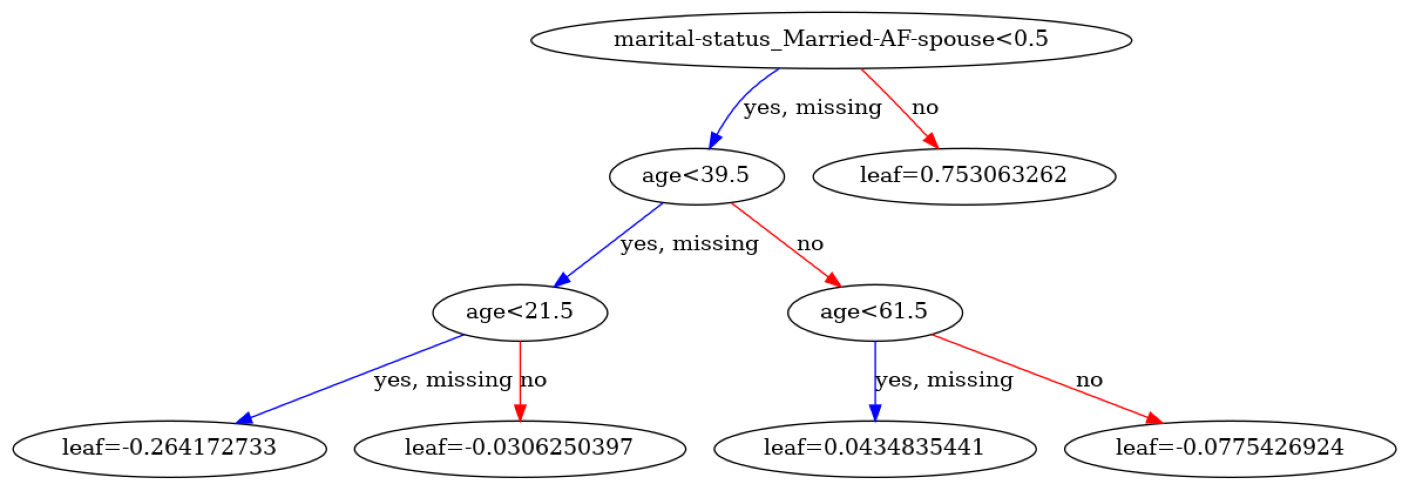

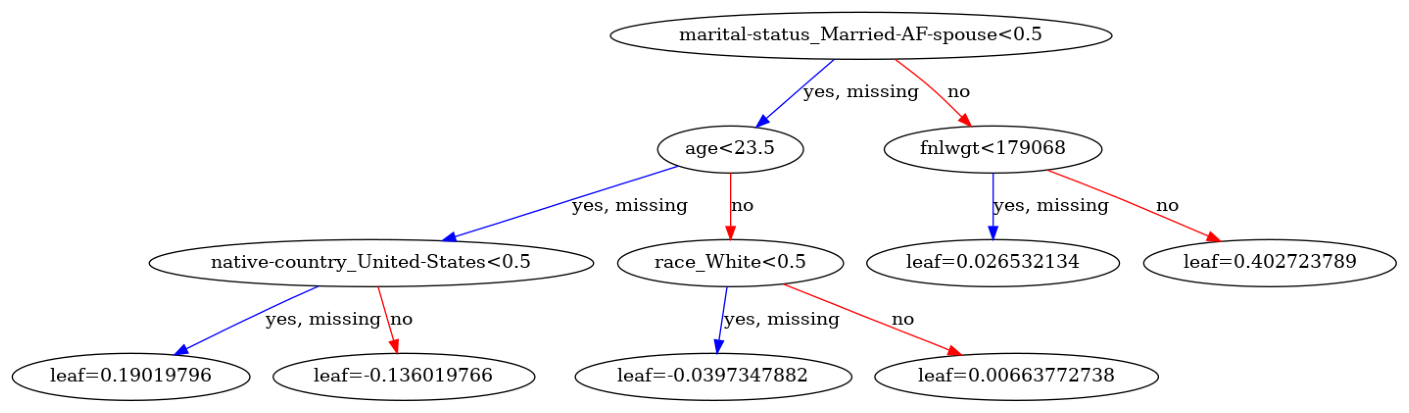

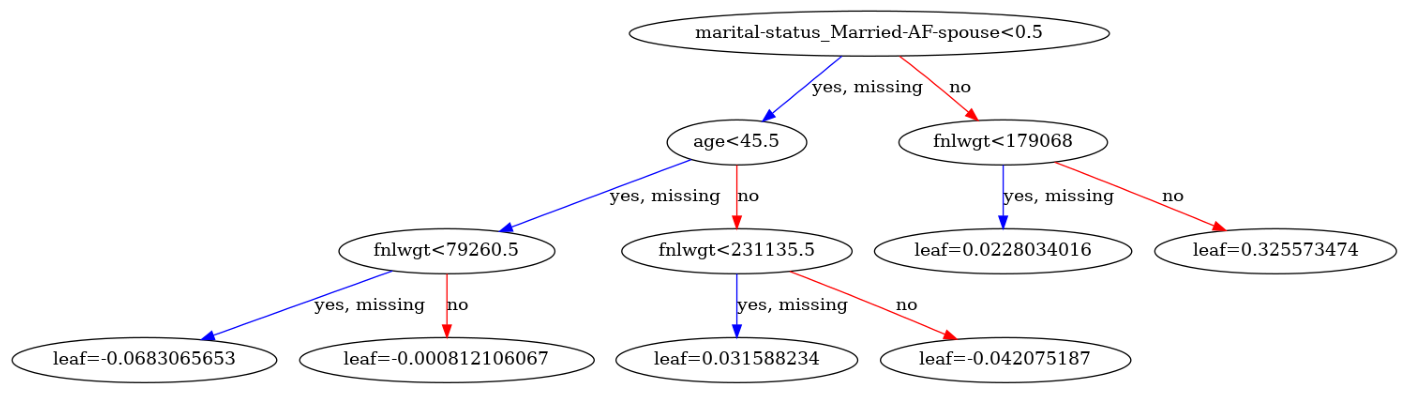

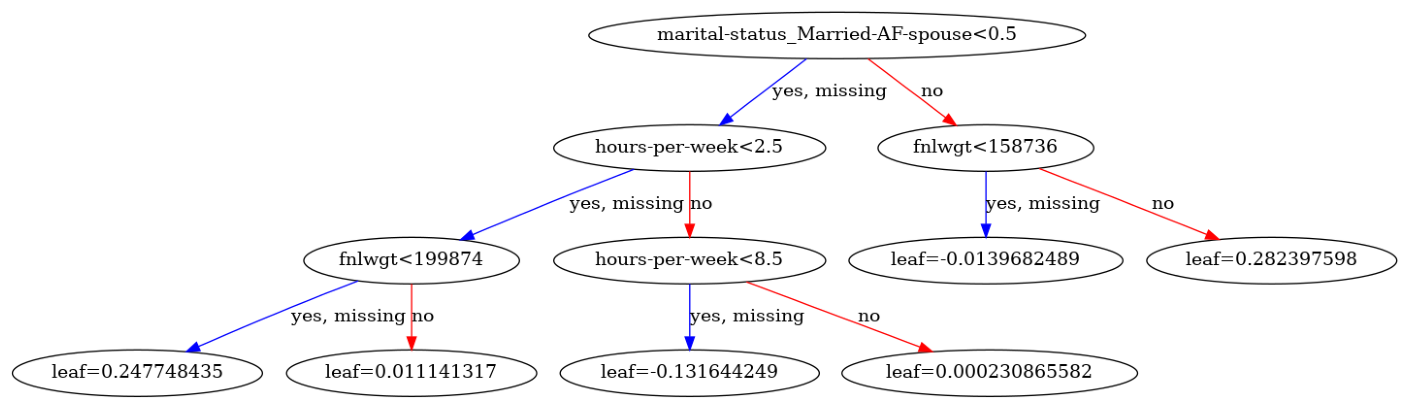

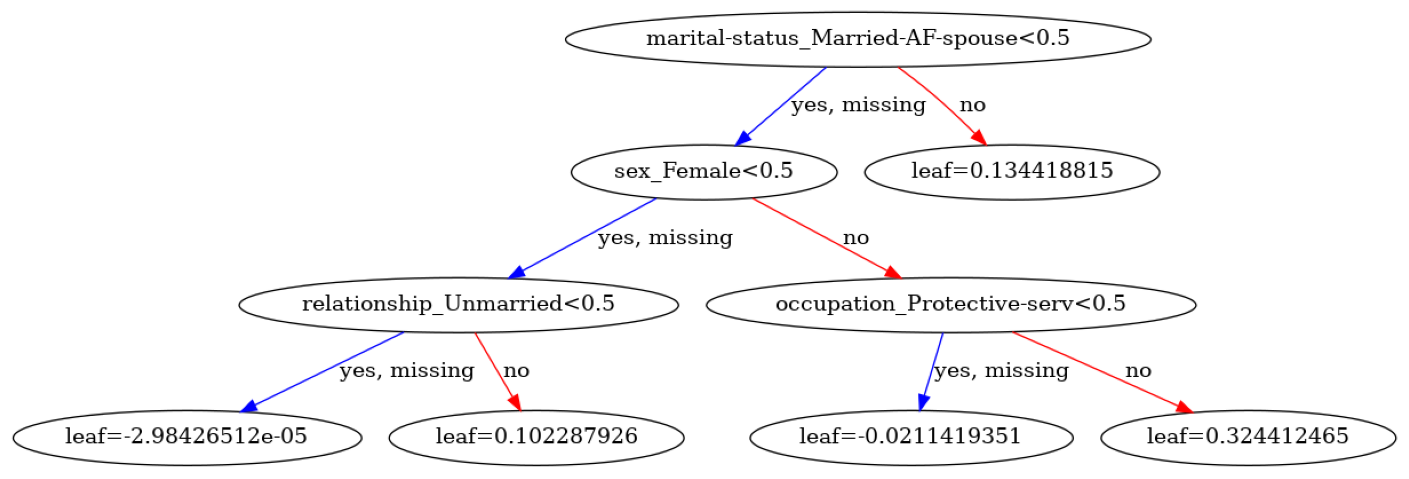

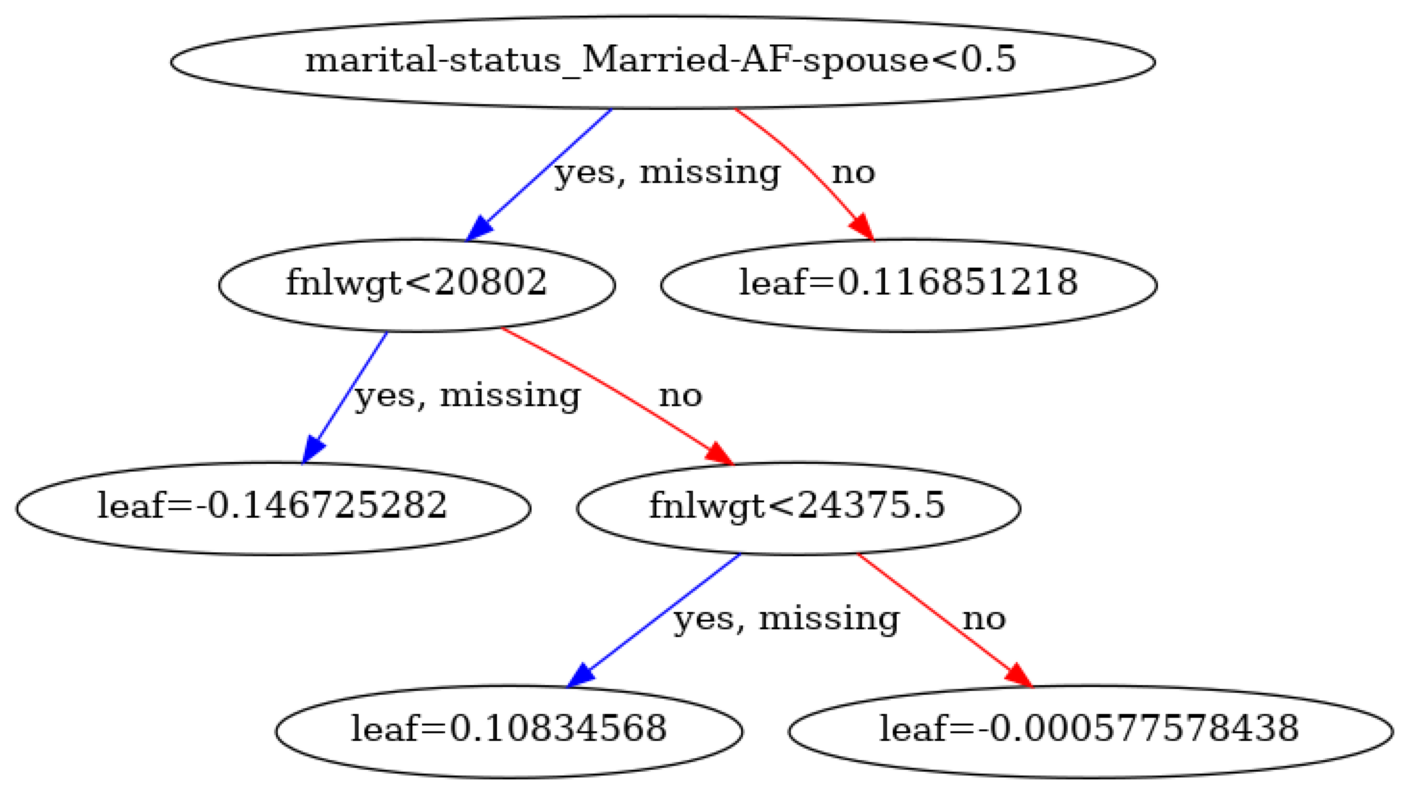

In [62]:
first_splitting_feature = df_first_splits.index[1]

print(f"first_splitting_feature: {first_splitting_feature}")

for num_trees in df_first_splits["trees_index"][first_splitting_feature]:
    
    plot_tree(
        booster=xgb_basic,
        num_trees=num_trees)

Parallell with the feature importance: aggregation over trees, but no "sense" or hierarchy between features... 

#Conclusion#
- The features importances does not reflect the structures of the trees
- The structures of the trees do not (systematically) follow a causal hierarchy (e.g. splitting on the income before the age) 
=> Further tests: the structures of trees need to be causally constrained (even if the split on "capital_gain" before "education_num" on a tree brought a bigger node purity on a tree number_k, that order would be forbidden as unrealistic)

Intuition: only keep the leaves that make sense 

Incident questions to realise this selection, or constraint, on trees: 
n_estimators = 1000, then why n_trees = 109?

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

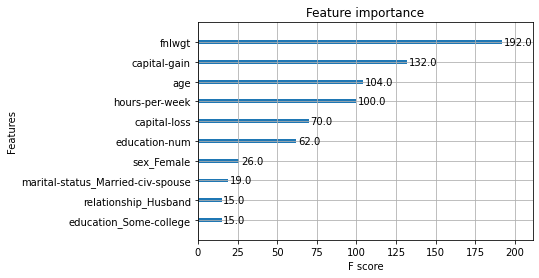

In [64]:
from xgboost.plotting import plot_importance 

# importance_type : str, default "weight"
        #How the importance is calculated: either "weight", "gain", or "cover"
        #* "weight" is the number of times a feature appears in a tree
        
plot_importance(
    booster=xgb_basic,
    importance_type="weight",
    max_num_features=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

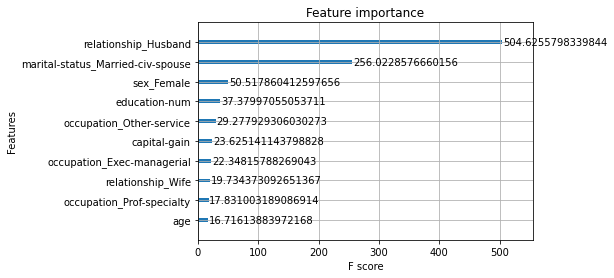

In [65]:
#* "gain" is the average gain of splits which use the feature
plot_importance(
    booster=xgb_basic,
    importance_type="gain",
    max_num_features=10)